# Estimation

In [253]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

import import_ipynb
from mergeClean import *

from doubleml import DoubleMLData
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [208]:
merged_df = pd.read_csv('data/final.csv')

In [209]:
cols = merged_df.columns.tolist()
covs = cols[:]
#covs = [x for x in cols if x != 'RETIRE' or x != 'ANNMILES_mean_nonnegative']
covs.remove('RETIRE')
covs.remove('ANNMILES_mean_nonnegative')
covs.remove('PRMACT_-1_PROP')
covs.remove('DRIVINGVEHICLE_-1_PROP')
covs.remove('WRKLOC_-1_PROP')

In [210]:
dml_target = DoubleMLData(merged_df,
                          y_col = 'ANNMILES_mean_nonnegative',
                          d_cols = 'RETIRE',
                          x_cols = covs)

In [211]:
obs = len(merged_df)
vars = 3
theta = 3
X = np.random.normal(size = (obs, vars))
d = np.dot(X[:, :3], np.array([5, 5, 5])) + np.random.standard_normal(size = (obs, ))
y = theta * d + np.dot(X[:, :3], np.array([5, 5, 5])) + np.random.standard_normal(size = (obs,))

In [212]:
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

learner = RandomForestRegressor(n_estimators = obs, max_features = 'sqrt', max_depth = 10)
ml_l_target = clone(learner)
ml_m_target = clone(learner)

learner = LassoCV()
ml_l_sim = clone(learner)
ml_m_sim = clone(learner)

## DML (Partial Linear)

In [213]:
from doubleml import DoubleMLPLR

np.random.seed(20020107)

obj_dml_plr_target = DoubleMLPLR(dml_target, ml_l_target, ml_m_target)
obj_dml_plr_target.fit()
print(obj_dml_plr_target)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: ANNMILES_mean_nonnegative
Treatment variable(s): ['RETIRE']
Covariates: ['HHFAMINC_IMP', 'HOMETYPE', 'URBRUR_2010', 'CDIVMSAR', 'CENSUS_R', 'DRVRCNT', 'HHSIZE', 'HHVEHCNT', 'HH_HISP', 'HH_RACE', 'HOMEOWN', 'MSACAT', 'MSASIZE', 'RAIL', 'URBAN', 'URBANSIZE', 'URBRUR', 'WRKCOUNT', 'COMMERCIALFREQ_mean_nonnegative', 'VEHAGE_mean', 'EDUC_amin', 'FRSTHM_amin', 'OUTOFTWN_amin', 'EDUC_amax', 'DELIVER_sum_nonnegative', 'DELIV_FOOD_sum_nonnegative', 'DELIV_GOOD_sum_nonnegative', 'DELIV_GROC_sum_nonnegative', 'DELIV_PERS_sum_nonnegative', 'EMPLOYMENT2_mean_nonnegative', 'ESCOOTERUSED_mean_nonnegative', 'GCDWORK_mean_nonnegative', 'MCTRANSIT_mean_nonnegative', 'MEDCOND6_mean_nonnegative', 'PTUSED_mean_nonnegative', 'RIDESHARE22_mean_nonnegative', 'TAXISERVICE_mean_nonnegative', 'WALKTRANSIT_mean_nonnegative', 'WKFMHM22_mean_nonnegative', 'CONDNIGH_min_nonnegative', 'C

## Sharp RDD with a triangle kernel (ITT)

In [276]:
merged_df = pd.read_csv('data/final.csv')
merged_df["R_AGE_min_nonnegative"] -= 65.5
merged_df = merged_df[(merged_df['R_AGE_min_nonnegative'] > -10) & (merged_df['R_AGE_min_nonnegative'] < 10)]

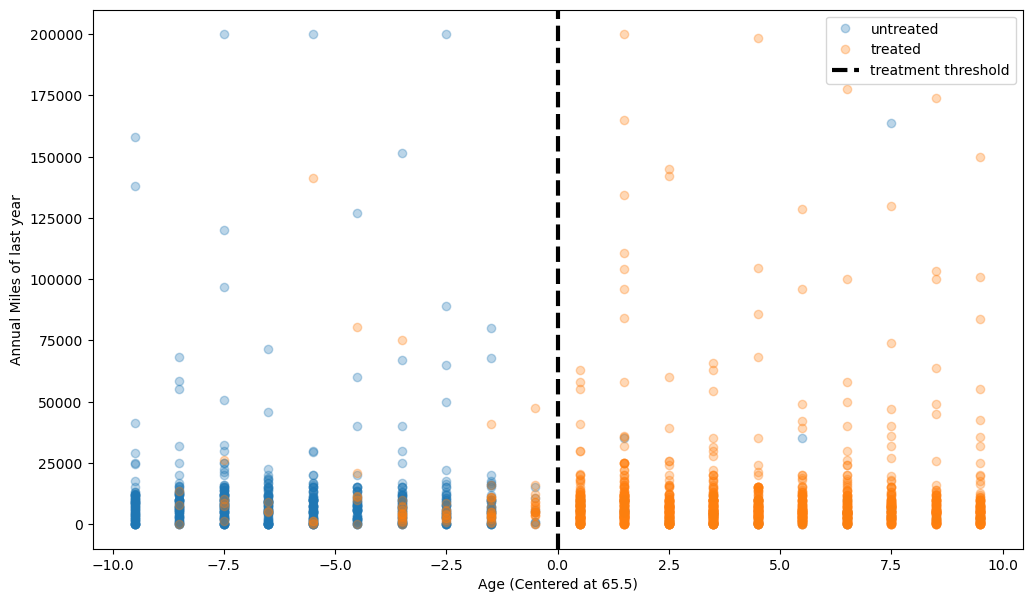

In [277]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(filtered_df.R_AGE_min_nonnegative[~filtered_df.RETIRE], 
        filtered_df.ANNMILES_mean_nonnegative[~filtered_df.RETIRE], "o", alpha=0.3, label="untreated")
ax.plot(filtered_df.R_AGE_min_nonnegative[filtered_df.RETIRE], 
        filtered_df.ANNMILES_mean_nonnegative[filtered_df.RETIRE], "o", alpha=0.3, label="treated")
ax.axvline(x=0, color="k", ls="--", lw=3, label="treatment threshold")
ax.set(xlabel=r"Age (Centered at 65.5)", ylabel=r"Annual Miles of last year")
ax.legend()

In [278]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)

    return indicator * (1 - np.abs(R-c)/h)

model = smf.wls("ANNMILES_mean_nonnegative ~ RETIRE * R_AGE_min_nonnegative", merged_df,
                weights=kernel(merged_df["R_AGE_min_nonnegative"], c=0, h=1)).fit()

print(model.summary())

                                WLS Regression Results                               
Dep. Variable:     ANNMILES_mean_nonnegative   R-squared:                       0.008
Model:                                   WLS   Adj. R-squared:                  0.007
Method:                        Least Squares   F-statistic:                     7.395
Date:                       Thu, 29 Feb 2024   Prob (F-statistic):           6.21e-05
Time:                               00:26:40   Log-Likelihood:                   -inf
No. Observations:                       2841   AIC:                               inf
Df Residuals:                           2837   BIC:                               inf
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

/Users/atchoo/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


/var/folders/3j/c66hjf350jb6gqkljs4lxvg00000gn/T/ipykernel_78509/1320476015.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treated_data['predicted'] = model.predict(treated_data)
/var/folders/3j/c66hjf350jb6gqkljs4lxvg00000gn/T/ipykernel_78509/1320476015.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  untreated_data['predicted'] = model.predict(untreated_data)


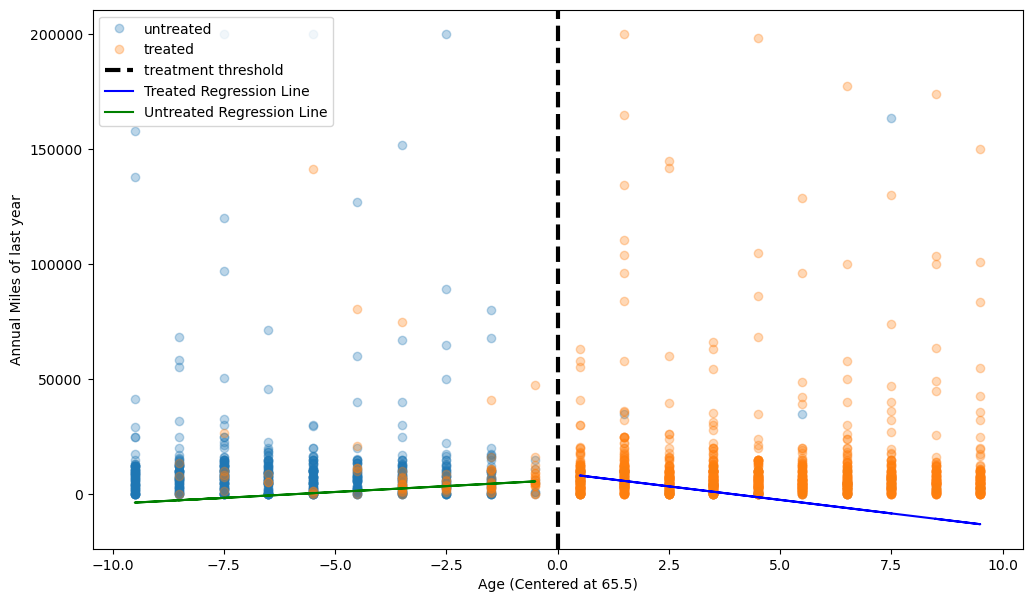

In [281]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Assuming you have already defined filtered_df and model

# Plotting the data points
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(filtered_df['R_AGE_min_nonnegative'][~filtered_df['RETIRE']], 
        filtered_df['ANNMILES_mean_nonnegative'][~filtered_df['RETIRE']], "o", alpha=0.3, label="untreated")
ax.plot(filtered_df['R_AGE_min_nonnegative'][filtered_df['RETIRE']], 
        filtered_df['ANNMILES_mean_nonnegative'][filtered_df['RETIRE']], "o", alpha=0.3, label="treated")

# Adding the treatment threshold line
ax.axvline(x=0, color="k", ls="--", lw=3, label="treatment threshold")

# Separate data into treated and untreated groups
treated_data = filtered_df[(filtered_df['RETIRE'] == 1) & (filtered_df['R_AGE_min_nonnegative'] >= 0)]
untreated_data = filtered_df[(filtered_df['RETIRE'] == 0) & (filtered_df['R_AGE_min_nonnegative'] <= 0)]

# Generate predicted values using the model
treated_data['predicted'] = model.predict(treated_data)
untreated_data['predicted'] = model.predict(untreated_data)

# Plotting the regression lines for treated and untreated groups
ax.plot(treated_data['R_AGE_min_nonnegative'], treated_data['predicted'], color='blue', label='Treated Regression Line')
ax.plot(untreated_data['R_AGE_min_nonnegative'], untreated_data['predicted'], color='green', label='Untreated Regression Line')

# Setting labels and legend
ax.set(xlabel=r"Age (Centered at 65.5)", ylabel=r"Annual Miles of last year")
ax.legend()

plt.show()

# Fuzzy RDD (LATE)

In [255]:
merged_df = pd.read_csv('data/final.csv')

merged_df['RETIRE'] = np.where(merged_df['RETIRE'], 1, 0)
merged_df['AGE_DUMMY'] = np.where(merged_df['R_AGE_min_nonnegative'] >= 65, 1, 0)

In [264]:
# First Stage
formula_first_stage = "RETIRE ~ AGE_DUMMY + np.subtract(R_AGE_min_nonnegative, 64.5)"
result_first_stage = smf.ols(formula = formula_first_stage, data = merged_df).fit()

In [265]:
# Second Stage
merged_df['ESTIMATED_TREATMENT'] = result_first_stage.predict(merged_df)
formula_second_stage = "ANNMILES_mean_nonnegative ~ ESTIMATED_TREATMENT + np.subtract(R_AGE_min_nonnegative, 64.5)"
result_second_stage = smf.wls(formula = formula_second_stage, data = merged_df).fit()
print(result_second_stage.summary())

                                WLS Regression Results                               
Dep. Variable:     ANNMILES_mean_nonnegative   R-squared:                       0.002
Model:                                   WLS   Adj. R-squared:                  0.001
Method:                        Least Squares   F-statistic:                     2.413
Date:                       Thu, 29 Feb 2024   Prob (F-statistic):             0.0897
Time:                               00:21:48   Log-Likelihood:                -33512.
No. Observations:                       2957   AIC:                         6.703e+04
Df Residuals:                           2954   BIC:                         6.705e+04
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------